# Analizando un conjunto de datos con Pandas

Analizaremos un archivo .xlsx el cual se extrajo de http://sinaiscap.salud.gob.mx:8080/DGIS/ el cual contiene los datos de los nacimientos por ocurrencia (es decir, los nacidos se registraron en el lugar de nacimiento) por año, desde el 2008 al 2024, en cada uno de los estados de la republica.

In [24]:
#Comenzamos instalando el paquete de la conexion con MySQL
!pip install mysql-connector-python

In [25]:
#importamos las librerias a utilizar
from mysql.connector import Error
from tabulate import tabulate
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from tabulate import tabulate

In [26]:
#Definimos nuestras funciones importantes
def connect_to_db(): #Hace la conexion con mysql
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="KevMun.11",
        database="proyecto"
    )

def test_connection(): #Revisa que la conexion este bien hecha
    connection = None 
    try:
        connection = mysql.connector.connect(
            host="localhost",
            user="root",
            password="KevMun.11",
            database="proyecto"
        )
        if connection.is_connected():
            print("Conexión exitosa")
    except Error as err:
        print(f"Error: {err}")
    finally:
        if connection is not None and connection.is_connected():
            connection.close()
            print("Conexión cerrada")

test_connection()


def fetch_data(query): #Recibe las instrucciones en lenguaje de mysql y devuelve un dataframe
    connection = connect_to_db()
    cursor = connection.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    cursor.close()
    connection.close()
    return df



Conexión exitosa
Conexión cerrada


## Manipulacion de datos

Comenzamos haciendo un dataframe usando una funcion y describiendo que tipos de datos tiene cada columna, todo en lenguaje MySQL. Posteriormente, comprobamos con Pandas y mostramos los primeros datos de nuestro dataframe.

In [154]:
query_original = "SELECT * FROM nacimientos;"
df_original = fetch_data(query_original)
query = "DESCRIBE nacimientos"
fetch_data(query)

,Field,Type,Null,Key,Default,Extra
0,Fecha,int,YES,,None,
1,EntidadFederativa,text,YES,,None,
2,Hombre,int,YES,,None,
3,Mujer,int,YES,,None,
4,NE,int,YES,,None,
5,SEIGNORA,int,YES,,None,
6,Total,int,YES,,None,


In [28]:
print(df_original.dtypes) 

Fecha                 int64
EntidadFederativa    object
Hombre                int64
Mujer                 int64
NE                    int64
SEIGNORA              int64
Total                 int64
dtype: object


In [29]:
df_original.head(16)

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2024,Nacional,219605,212292,110,0,432007
1,2024,Aguascalientes,2408,2399,0,1,4807
2,2024,Baja California,6097,5962,2,0,12061
3,2024,Baja California Sur,1482,1458,0,0,2940
4,2024,Campeche,1484,1470,3,0,2957
5,2024,Coahuila,6294,6056,1,0,12351
6,2024,Colima,1332,1337,0,0,2669
7,2024,Chiapas,9963,9717,10,0,19690
8,2024,Chihuahua,6950,6541,3,0,13494
9,2024,CDMX,14658,14151,8,0,28817


Algo que podemos ver es que el renglon 1 no inicia con un estado de la republica, sino que tiene la palabra "Nacional" por lo que ese renglon no nos aporta informacion.
Algo que podemos inferir es que esto ocurre al inicio de cada año, los siguientes dos fracmentos de codigo nos muestra la informacion del renglon 33 y renglon 66, los cuales tienen la misma informacion en Entidad Federativa que el renglon 1.

In [34]:
df_original.iloc[33]

Fecha                    2023
EntidadFederativa    Nacional
Hombre                 774325
Mujer                  746334
NE                        621
SEIGNORA                    0
Total                 1521280
Name: 33, dtype: object

In [36]:
df_original.iloc[66]

Fecha                    2022
EntidadFederativa    Nacional
Hombre                 826549
Mujer                  795243
NE                       1120
SEIGNORA                    9
Total                 1622921
Name: 66, dtype: object

Usando un SELECT podemos ver que no solo hay un par de estos caso sino que hay 17.

In [39]:
query = "SELECT * FROM nacimientos WHERE EntidadFederativa = 'Nacional'"
df = fetch_data(query)
df

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2024,Nacional,219605,212292,110,0,432007
1,2023,Nacional,774325,746334,621,0,1521280
2,2022,Nacional,826549,795243,1120,9,1622921
3,2021,Nacional,833880,804310,1274,15,1639479
4,2020,Nacional,889926,856349,942,630,1747847
5,2019,Nacional,949986,916817,1411,0,1868214
6,2018,Nacional,987679,951465,1512,0,1940656
7,2017,Nacional,1050799,1012191,1513,0,2064503
8,2016,Nacional,1056919,1021622,1712,0,2080253
9,2015,Nacional,1092738,1050898,1563,0,2145199


Dado que no nos aportan informacion que queremos, procedemos a quedarnos solamente con los que la Entidad Federativa no llevan por nombre Nacional y visualizamos para confirmar que ya no estan esos renglones.

In [41]:
df_original = df_original[df_original['EntidadFederativa']!= 'Nacional']
df_original.head(2)

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
1,2024,Aguascalientes,2408,2399,0,1,4807
2,2024,Baja California,6097,5962,2,0,12061


La primera vez que visualizamos nuestro dataframe se puede ver que el Estado de Mexico lleva por nombre "MÃ©xico" lo cual puede ser confuso a la hora de visualizar el comportamiento de los datos, asi que se usa el metodo .replace para que en todos los renglones donde hay una cadena con "MÃ©xico" por entidad Federativa la cambie a "Estado de Mexico", lo mismo hacemos con entiedades que tengan tilde, y visualizamos para confirmar.

In [92]:

df_original['EntidadFederativa'] = df_original['EntidadFederativa'].replace({'MÃ©xico':'Estado de Mexico', 'MichoacÃ¡n': 'Michoacan', 'Nuevo LeÃ³n':'Nuevo Leon', 'QuerÃ©taro':'Queretaro','San Luis PotosÃ­':'San Luis Potosi', 'YucatÃ¡n':'Yucatan'})
df_original.head(33)


,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
1,2024,Aguascalientes,2408,2399,0,1,4807
2,2024,Baja California,6097,5962,2,0,12061
3,2024,Baja California Sur,1482,1458,0,0,2940
4,2024,Campeche,1484,1470,3,0,2957
5,2024,Coahuila,6294,6056,1,0,12351
6,2024,Colima,1332,1337,0,0,2669
7,2024,Chiapas,9963,9717,10,0,19690
8,2024,Chihuahua,6950,6541,3,0,13494
9,2024,CDMX,14658,14151,8,0,28817
10,2024,Durango,3474,3349,2,0,6825


## Analisis de los datos

Tomaremos de base el año 2021 y veremos si durante a pandemia hubo mas o menos nacimientos que en el 2019 y 2020, ya que el confinamiento ponia a las parejas mayor tiempo juntas.
Tambien, al ser, actualmente, el Estado de Mexico, la Cuidad de Mexico y Jalisco las entidades con mayor poblacion veamos la media de cada uno a lo largo de estos 16 años.
Primero lo hacemos con MySQL. (Estos tres yo se que pude juntar los tres en un AND pero por alguna razon no compilaba)

In [93]:
query1 = "SELECT * FROM nacimientos WHERE Fecha = 2021 and EntidadFederativa = 'CDMX'"
df_cdmx21 = fetch_data(query1)
df_cdmx21

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2021,CDMX,46492,44831,40,1,91364


In [94]:
query2 = "SELECT * FROM nacimientos WHERE Fecha = 2021 and EntidadFederativa = 'Jalisco'"
df_jal21 = fetch_data(query2)
df_jal21

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2021,Jalisco,55492,52941,112,0,108545


In [95]:
query3 = "SELECT * FROM nacimientos WHERE Fecha = 2021 and EntidadFederativa = 'MÃ©xico'"
df_mex21 = fetch_data(query3)
df_mex21

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2021,MÃ©xico,68758,66502,74,3,135337


In [ ]:
Y lo corroboramos con Pandas.

In [97]:
df_2021 = df_original[df_original['Fecha'] == 2021]
df_2021_cdmx = df_2021[(df_2021['EntidadFederativa'] == 'CDMX')|(df_2021['EntidadFederativa'] == 'Estado de Mexico')|(df_2021['EntidadFederativa'] == 'Jalisco')]
df_2021_cdmx

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
108,2021,CDMX,46492,44831,40,1,91364
113,2021,Jalisco,55492,52941,112,0,108545
114,2021,Estado de Mexico,68758,66502,74,3,135337


Podemos visualizar el hecho de que la Cuidad de Mexico, el Estado de Mexico y Jaisco sean las cuidades mas nacimientos en promedio a lo largo del lapso de tiempo 2008-2004 en la siguiente grafica:


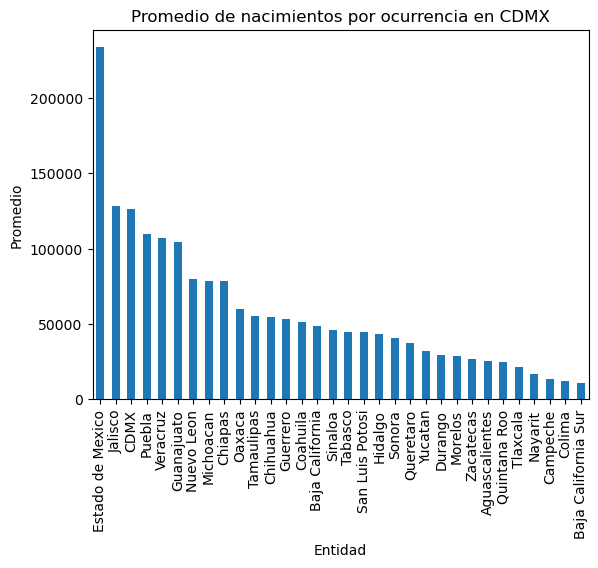

In [107]:
prom_entidad = df_original.groupby('EntidadFederativa')['Total'].mean().sort_values(ascending=False)
prom_entidad.plot(kind='bar', title='Promedio de nacimientos por ocurrencia en CDMX')
plt.xlabel('Entidad')
plt.ylabel('Promedio')
plt.show()

Actualmente sabemos que la poblacion del Estado de Mexico supera a la Ciudad de Mexico por casi el doble, pero la Cuidad de Mexico y Jalisco distan por poco menos de un millon. Con el dataframe mostrado anteriorente podemos ver que algo parecido sucede con los nacimientos entre la Cuidad de Mexico y el Estado de Mexico (pues esta a casi 40,000 nacimientos de diferencia), mientras que la Ciudad de Mexico y Jalisco en ese año tienen de diferencia cerca de 17,000 nacimientos.

Dado que la diferencia entre Cuidad de Mexico y Jalisco es mas pequeña, nos centraremos en ver sus diferencias en los dos años anteriores.

Como podemos ver, para el año 2019 solamente hubo una diferencia de alrededor de 10,000 nacimientos en favor de la Jalisco. Lo cual es interesante, ya que todos tenemos la idea de que la Cuidad de Mexico es la gran Metropolis y siempre esta en crecimiento.


Para esto lo hacemos primero en MySQL y corroboramos en Pandas.

In [158]:
query1 = "SELECT * FROM nacimientos WHERE Fecha = 2019 and EntidadFederativa = 'CDMX'"
df_cdmx19 = fetch_data(query1)
df_cdmx19

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2019,CDMX,58672,56985,72,0,115729


In [159]:
query2 = "SELECT * FROM nacimientos WHERE Fecha = 2019 and EntidadFederativa = 'Jalisco'"
df_jal19 = fetch_data(query2)
df_jal19

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2019,Jalisco,64509,62242,90,0,126841


In [102]:
df_2019 = df_original[df_original['Fecha'] == 2019]
df_2019_EmxJal = df_2019[(df_2019['EntidadFederativa'] == 'CDMX')|(df_2019['EntidadFederativa'] == 'Jalisco')]
df_2019_EmxJal

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
174,2019,CDMX,58672,56985,72,0,115729
179,2019,Jalisco,64509,62242,90,0,126841


Para el año 2020 las cantidades se alejan por casi 18,000 nacimientos, nuevamente a favor de Jalisco.

In [105]:
query1 = "SELECT * FROM nacimientos WHERE Fecha = 2020 and EntidadFederativa = 'CDMX'"
df_cdmx20 = fetch_data(query1)
df_cdmx20

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2020,CDMX,52293,49913,26,34,102266


In [106]:
query2 = "SELECT * FROM nacimientos WHERE Fecha = 2020 and EntidadFederativa = 'Jalisco'"
df_jal20 = fetch_data(query2)
df_jal20

,Fecha,EntidadFederativa,Hombre,Mujer,NE,SEIGNORA,Total
0,2020,Jalisco,61443,58497,35,34,120009


In [ ]:
df_2020 = df_original[df_original['Fecha'] == '2020-01-01']
df_2020_EmxJal = df_2020[(df_2020['Entidad Federativa'] == 'CDMX')|(df_2020['Entidad Federativa'] == 'Jalisco')]
df_2020_EmxJal

,Año,Entidad Federativa,Hombre,Mujer,NE,SE IGNORA,Total
141,2020-01-01,CDMX,52293,49913,26,34,102266
146,2020-01-01,Jalisco,61443,58497,35,34,120009


Con el analisis de esos tres años podemos ver que la diferencia entre ambos es ascendente, con cada año que transcurre la diferencia se hace mas marcada y siempre a favor de Jalisco.
Podemos observar tambien algo que es importante, conforme el año crece los nacimientos disminuyen.

Ahora, con la motivacion de que los nacimientos disminuyen veamos si eso ocurre retrocediendo mas en el tiempo, para esto nos ayudaremos de una grafica de barras donde el Eje x seran los años y el Eje y contiene el valor de la media de nacimientos de la Cuidad de Mexico.


En dicha grafica podemos ver que desde el año 2012 el promedio de nacimientos en esta entidad tiene tendencia decresciente hasta el año 2022.

In [142]:
query = "SELECT Fecha,AVG(Total) FROM nacimientos WHERE EntidadFederativa = 'CDMX' GROUP BY Fecha "
df_promcdmx = fetch_data(query)
df_promcdmx


,Fecha,AVG(Total)
0,2024,28817.0000
1,2023,92933.0000
2,2022,96139.0000
3,2021,91364.0000
4,2020,102266.0000
5,2019,115729.0000
6,2018,120019.0000
7,2017,132363.0000
8,2016,139730.0000
9,2015,146688.0000


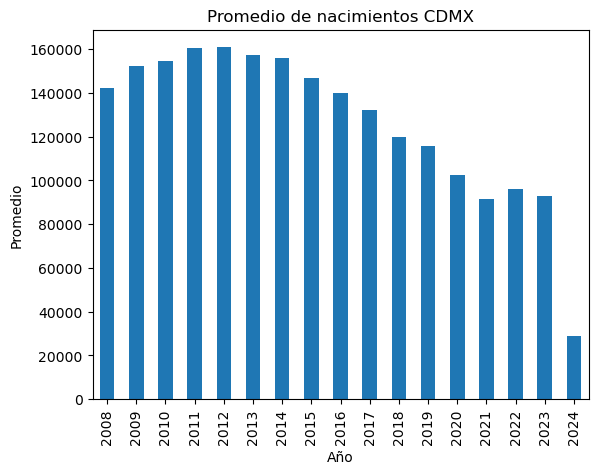

In [151]:
df_anio = df_original.groupby('Fecha')['Total'].mean()
df_anio_cdmx = df_original[df_original['EntidadFederativa'] == 'CDMX'].groupby('Fecha')['Total'].mean()


df_anio_cdmx.plot(kind='bar', title='Promedio de nacimientos CDMX')
plt.xlabel('Año')
plt.ylabel('Promedio')
plt.show()


Hacemos lo propio con Jalisco y podemos apreciar que tiene un comportamiento similar al grafico de la Ciudad de Mexico, salvo que los años 2021, 2022 y 2023 tiene promedios similares.

In [153]:
query = "SELECT Fecha,AVG(Total) FROM nacimientos WHERE EntidadFederativa = 'Jalisco' GROUP BY Fecha "
df_promjal = fetch_data(query)
df_promjal


,Fecha,AVG(Total)
0,2024,29962.0000
1,2023,104536.0000
2,2022,108852.0000
3,2021,108545.0000
4,2020,120009.0000
5,2019,126841.0000
6,2018,129379.0000
7,2017,140725.0000
8,2016,141313.0000
9,2015,146190.0000


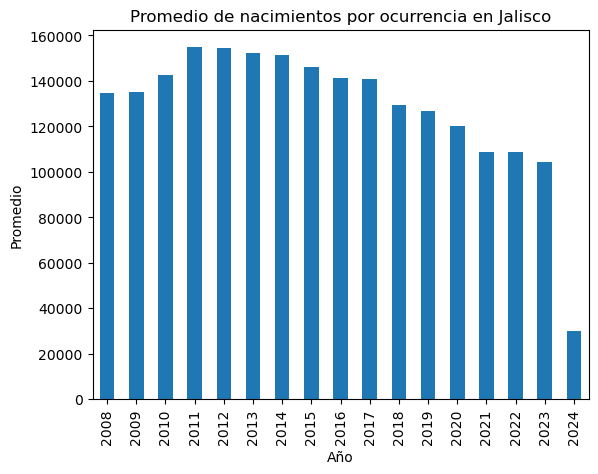

In [122]:
df_anio_jal = df_original[df_original['EntidadFederativa'] == 'Jalisco'].groupby('Fecha')['Total'].mean()


df_anio_jal.plot(kind='bar', title='Promedio de nacimientos por ocurrencia en Jalisco')
plt.xlabel('Año')
plt.ylabel('Promedio')
plt.show()


Comparemos en una misma grafica como se comportan los datos de las dos graficas anteriores.
Dado que los datos del 2024 aun no estan completos los quitaremos de nuestros datos y obtener una mejor grafica.

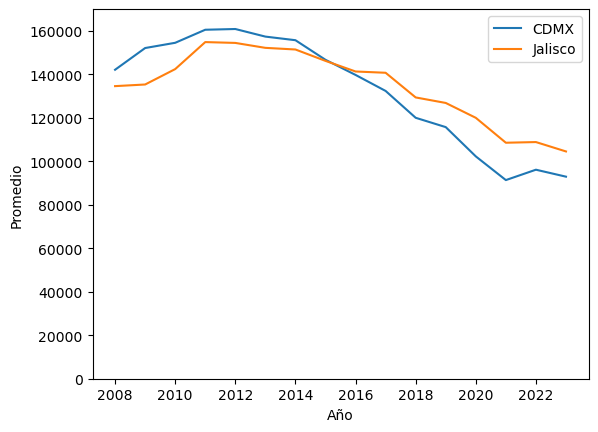

In [121]:
df_anio_cdmx = df_anio_cdmx[df_anio_cdmx.index != 2024]
df_anio_jal = df_anio_jal[df_anio_jal.index != 2024]
plt.plot(df_anio_cdmx)
plt.plot(df_anio_jal)
plt.legend(['CDMX', 'Jalisco'])
plt.ylim(0, 170000)
plt.xlabel('Año')
plt.ylabel('Promedio')
plt.show()

Algo que podemos notar en que Jalisco no siempre tuvo mayor nuemros de nacimientos que la Cuidad de Mexico, sino que Jalisco empieza a dominar apartir del año 2016 hasta el 2023.

Tambien, podemos notar que en el año 2021 es donde se tiene un bajon mas pronunciado en el numero de nacimientos, contrario a lo que supoinia que iba a pasar.

Por ultimo, veamos que la tendencia negativa no se tiene solo en estos estados, sino que es a nivel nacional.
Lo podemos visualizar a continuacion.

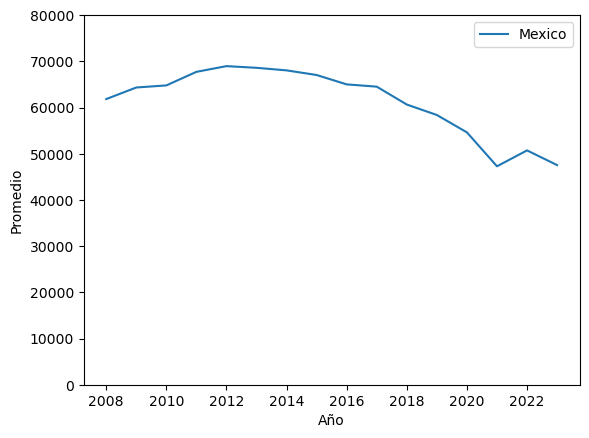

In [123]:
df_anio = df_anio[df_anio.index != 2024]
plt.plot(df_anio)
plt.legend(['Mexico'])
plt.ylim(0, 80000)
plt.xlabel('Año')
plt.ylabel('Promedio')
plt.show()

## Reflexion





1.   El Estado de Mexico tiene muchos mas nacimientos que cualquier otro estado de la Republica Mexicana.
2.   Jalisco y la Cuidad de Mexico tiene numero de nacimientos parecidos.
3. La Cuidad de Mexico se vio rebasada en nacimientos por Jalisco, por lo que probablemente pronto Jalisco se pueda situar como la segunda entidad con mayor poblacion del pais (habria que ver lo que sucede con las defunciones).
4. El confinamiento no trajo un incremento en el numero de naciemientos, sino que tuvo un decremento pronunciado salvo un ligero pico en 2022.
5. Actualmente el promedio nacional de nacimientos tiene tendencia descendente, lo cual puede sugerir que a los jovenes no les interesa tener hijos.

